# RadIOCD

In [20]:
# Download RadIOCD
# !wget https://zenodo.org/records/10554924/files/RadIOCD.zip
# !wget https://zenodo.org/records/10554924/files/df_4_annotation.csv
# !unzip RadIOCD.zip

In [21]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

In [22]:
path = 'dataset/'
subjects = ['subject_1/', 'subject_2/', 'subject_3/', 'subject_4/', 'subject_5/', 
            'subject_6/', 'subject_7/', 'subject_8/', 'subject_9/', 'subject_10/'] 

classes = {'wall':4,'human':3,'desk':2,'chair':1,'backpack':0}

In [23]:
# read df_4_annotation.csv to simplify io and feature extraction
df_4_annotation = pd.read_csv('df_4_annotation.csv')
dfs_csvs = df_4_annotation['CSV'].unique()

In [27]:
threshold_frames = 8 #how many frames in a csv file should contain the object of interest
threshold_gap = 2 #how many frames in a specified window should not contain the object of interest
window = 10 #how many frames contitute a window

100%|██████████| 5776/5776 [04:44<00:00, 20.28it/s]


In [ ]:
counter = 0
# init features daraframe
features = pd.DataFrame({'object':[],'subject':[],'min_X':[],'max_X':[],'mean_X':[],'std_X':[],'env':[],
                                        'min_Y':[],'max_Y':[],'mean_Y':[],'std_Y':[],
                                        'min_Z':[],'max_Z':[],'mean_Z':[],'std_Z':[],'csv':[]})

for i in tqdm(dfs_csvs):
    cdf = pd.read_csv(i)
    splits = i.split('/')
    current_subject = splits[1]
    current_env = splits[2]
    current_object = splits[3]
    current_csv = i
    
    #check if there is an object detected in the current csv file
    if 'Presence' in cdf.columns:
        #check how many frames contain an object 
        un_frames = cdf['Frame #'][cdf['Presence']==1].unique()

        if len(un_frames)<threshold_frames:
            continue
        else:
            for gr in un_frames:
                array = np.arange(gr,gr+window)
                set1 = set(array) 
                set2 = set(un_frames) 
                
                #if the are more "empty" frames than the defined threshold continue
                if len(set1.union(set2))-len(set2)>threshold_gap:
                    continue
                elif (array[-1] not in cdf['Frame #'].values):
                    continue
                else:
                    current_cdf = cdf[(cdf['Frame #']>=array[0]) & (cdf['Frame #']<=array[-1])]
                    if len(current_cdf['Frame #'].unique())<(window-1):
                        print('Error less than expected frames')
                    points_df = current_cdf[current_cdf['Presence']==1]
                    
                    #Get values only if the object is closer than 2.5 meters
                    if np.mean(points_df['Y'])<2.5:
                        current_features = pd.DataFrame({'object':[current_object],'subject':[current_subject],'env':[current_env],
                                                         'min_X':[np.min(points_df['X'])],'max_X':[np.max(points_df['X'])],
                                                         'mean_X':[np.mean(points_df['X'])],'std_X':[np.std(points_df['X'])],
                                                         'min_Y':[np.min(points_df['Y'])],'max_Y':[np.max(points_df['Y'])],
                                                         'mean_Y':[np.mean(points_df['Y'])],'std_Y':[np.std(points_df['Y'])],
                                                         'min_Z':[np.min(points_df['Z'])],'max_Z':[np.max(points_df['Z'])],
                                                         'mean_Z':[np.mean(points_df['Z'])],'std_Z':[np.std(points_df['Z'])],
                                                        'n_points':[current_cdf['Presence'].sum()],'csv':[current_csv]})
                        features = pd.concat([features,current_features],ignore_index=True)

In [7]:
# store features to csv file
features.to_csv('features.csv',index=False)

In [8]:
features = pd.read_csv('features.csv')

In [9]:
features = features.replace(classes)

In [10]:
features = features.replace({'subject_1': 1,'subject_2': 2,'subject_3': 3,
                            'subject_4': 4,'subject_5': 5,'subject_6': 6,
                            'subject_7': 7,'subject_8': 8,'subject_9': 9,'subject_10': 10, })

In [11]:
#define set of features
feats = ['min_X', 'max_X', 'mean_X', 'std_X','min_Y', 'max_Y', 'mean_Y', 'std_Y', 'min_Z', 
         'max_Z', 'mean_Z','std_Z','n_points']

# ML subject-dependent 

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [13]:
kf = KFold(n_splits=10, random_state=12, shuffle=True)

In [14]:
def z_score(X_train, X_test):
    x_means = np.zeros(len(feats))
    x_stds = np.zeros(len(feats))
    for i in range(len(feats)):
        x_means[i] = np.mean(X_train[:,i])
        x_stds[i] = np.std(X_train[:,i])

        X_train[:,i] = (X_train[:,i]-x_means[i])/x_stds[i]
        X_test[:,i] = (X_test[:,i]-x_means[i])/x_stds[i]
    return X_train, X_test

In [15]:
test_acc = []
conf_mats = []
f1s = []

for i, (train_index, test_index) in enumerate(kf.split(features['csv'].unique())):
    csv_train = features['csv'].unique()[train_index]
    csv_test = features['csv'].unique()[test_index]

    X_train = features[feats][(features['csv'].isin(csv_train))].to_numpy()
    y_train = features['object'][(features['csv'].isin(csv_train))].to_numpy()

    X_test = features[feats][(features['csv'].isin(csv_test))].to_numpy()
    y_test = features['object'][(features['csv'].isin(csv_test))].to_numpy()
    
    X_train, X_test = z_score(X_train, X_test)
      
    # change this accordingly
    rf = RandomForestClassifier(n_estimators=30, max_depth=20)
    rf.fit(X_train,y_train)
    
    test_acc.append(np.mean(rf.predict(X_test)==y_test))
    preds = rf.predict(X_test)
    
    print('Train:',np.mean(rf.predict(X_train)==y_train))
    print('Test:',np.mean(rf.predict(X_test)==y_test))
    print(f1_score(y_test, preds, average='macro'))

    conf_mats.append(confusion_matrix(y_test,preds, labels=[0,1,2,3,4]))
    f1s.append(f1_score(y_test, preds, average='macro'))
print()
print(np.mean(test_acc))
print(np.mean(f1s))

Train: 0.9897923525408766
Test: 0.7400193174500966
0.7241721191681713
Train: 0.9892019555947654
Test: 0.7475303643724697
0.7277495383038914
Train: 0.9889526081570859
Test: 0.7226828667597077
0.6980424458036256
Train: 0.9898085549429885
Test: 0.73265860281412
0.7122155595068923
Train: 0.9892190929041698
Test: 0.7397933254277486
0.7243215544869559
Train: 0.9884282819391339
Test: 0.7269348310894523
0.697011272957233
Train: 0.9902358075399736
Test: 0.7443360343972217
0.7208201528130234
Train: 0.9895281248569728
Test: 0.7270363224561698
0.6997663540483413
Train: 0.9902534648749164
Test: 0.7198099841653471
0.7069764561367288
Train: 0.9893428715550052
Test: 0.7233533921358503
0.7011941373503583

0.7324155041068183
0.711226959057522


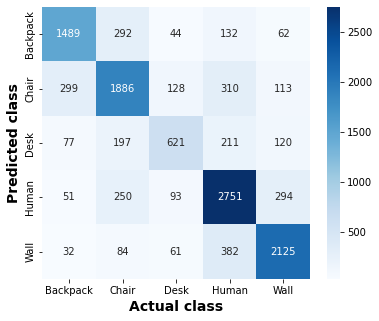

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 1000
%matplotlib inline
classe = ["Backpack", "Chair", "Desk", "Human", "Wall"]

mean_cf = np.mean([i for i in conf_mats],0)
mean_cf

df_cm = pd.DataFrame(mean_cf.astype(int), index = [i for i in classe],columns = [i for i in classe])
plt.figure(figsize = (6,5))


ax = sn.heatmap(df_cm, annot=True,fmt='g',cmap='Blues')

ax.set_xlabel(xlabel='Actual class', fontsize=14, fontdict=dict(weight='bold'))
ax.set_ylabel(ylabel='Predicted class', fontsize=14, fontdict=dict(weight='bold'))

plt.savefig('conf_mat_ppg_cross_attention.png', dpi=1000)

# ML Subject Independent

In [51]:
test_acc = []
conf_mats = []
f1s = []
for s in range(1,11):
    X_train = features[feats][(features['subject']!=s)].to_numpy()
    y_train = features['object'][(features['subject']!=s)].to_numpy()

    X_test = features[feats][(features['subject']==s)].to_numpy()
    y_test = features['object'][(features['subject']==s )].to_numpy()
    
    X_train, X_test = z_score(X_train, X_test)
        
    rf = RandomForestClassifier(n_estimators=30, max_depth=20)
    rf.fit(X_train,y_train)
    
    test_acc.append(np.mean(rf.predict(X_test)==y_test))
    preds = rf.predict(X_test)
    
    print('Train:',np.mean(rf.predict(X_train)==y_train))
    print('Test:',np.mean(rf.predict(X_test)==y_test))
    print(f1_score(y_test, preds, average='macro'))

    conf_mats.append(confusion_matrix(y_test,preds, labels=[0,1,2,3,4]))
    f1s.append(f1_score(y_test, preds, average='macro'))
print()
print(np.mean(test_acc))
print(np.mean(f1s))

Train: 0.9891361521343314
Test: 0.7920738814668699
0.7835653279239463
Train: 0.9903763246460657
Test: 0.6316976027654618
0.5767967641156023
Train: 0.9917501364187084
Test: 0.68458176799816
0.6432691165139571
Train: 0.9896561094699194
Test: 0.5222175201015659
0.5069299110996992
Train: 0.9883179251052197
Test: 0.6691073219658977
0.6177318424493948
Train: 0.9892493348025909
Test: 0.6238868517548455
0.5688031806424405
Train: 0.9900323636136694
Test: 0.6304565144951683
0.5763580285302033
Train: 0.9893872024299647
Test: 0.6518037761294673
0.6297823808515872
Train: 0.9913930943744461
Test: 0.6162641863640242
0.602698964648189
Train: 0.9873152458134747
Test: 0.8744744744744745
0.87308499445102

0.6696563897515934
0.637902051122604


In [17]:
np.mean(np.array(conf_mats),0)

array([[1489.5,  292.3,   44.8,  132.4,   62.1],
       [ 299. , 1886.3,  128.4,  310.3,  113.7],
       [  77.8,  197.8,  621.7,  211.6,  120.4],
       [  51.8,  250.1,   93.7, 2751.7,  294.9],
       [  32.6,   84.4,   61.6,  382. , 2125.7]])

# Deep Learning Subject Dependent

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-01-19 16:25:53.454468: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 16:25:55.225377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 16:26:00.948024: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [270]:
test_acc = []
conf_mats = []
f1s = []

for i, (train_index, test_index) in enumerate(kf.split(features['csv'].unique())):
    csv_train = features['csv'].unique()[train_index]
    csv_test = features['csv'].unique()[test_index]

    X_train = features[feats][(features['csv'].isin(csv_train))].to_numpy()
    y_train = features['object'][(features['csv'].isin(csv_train))].to_numpy()

    X_test = features[feats][(features['csv'].isin(csv_test))].to_numpy()
    y_test = features['object'][(features['csv'].isin(csv_test))].to_numpy()
    
    X_train, X_test = z_score(X_train, X_test)
        
    Y_train = to_categorical(y_train, num_classes=5)
    Y_test = to_categorical(y_test, num_classes=5)

    model = Sequential()
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(5, activation='softmax'))

    early_stopping = EarlyStopping(monitor='val_accuracy',patience=50, mode='max')

    model.build(input_shape=X_train.shape)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint('best_weights_dense_'+str(i)+'.hdf5', 
                                 monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    model.summary()
    model.fit(X_train, Y_train, batch_size=128, epochs=1000, 
              validation_data=(X_test, Y_test), callbacks=[early_stopping, checkpoint])
    model.load_weights('best_weights_dense_'+str(i)+'.hdf5')
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    
    preds = np.argmax(model.predict(X_test),1)
    test_acc.append(np.mean(preds==y_test))
    print(f1_score(y_test, preds, average='macro'))

    conf_mats.append(confusion_matrix(y_test,preds, labels=[0,1,2,3,4]))
    f1s.append(f1_score(y_test, preds, average='macro'))
print()
print(np.mean(test_acc))
print(np.mean(f1s))



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (108742, 256)             3584      
                                                                 
 dropout_4 (Dropout)         (108742, 256)             0         
                                                                 
 dense_6 (Dense)             (108742, 256)             65792     
                                                                 
 dropout_5 (Dropout)         (108742, 256)             0         
                                                                 
 dense_7 (Dense)             (108742, 128)             32896     
                                                                 
 dropout_6 (Dropout)         (108742, 128)             0         
                                                                 
 dense_8 (Dense)             (108742, 128)            

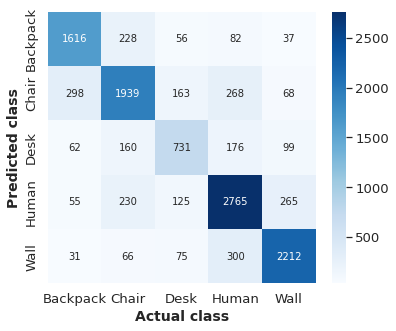

In [271]:
import seaborn as sn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 1000
%matplotlib inline
classe = ["Backpack", "Chair", "Desk", "Human", "Wall"]

mean_cf = np.mean([i for i in conf_mats],0)
mean_cf

df_cm = pd.DataFrame(mean_cf.astype(int), index = [i for i in classe],columns = [i for i in classe])
plt.figure(figsize = (6,5))


ax = sn.heatmap(df_cm, annot=True,fmt='g',cmap='Blues')

ax.set_xlabel(xlabel='Actual class', fontsize=14, fontdict=dict(weight='bold'))
ax.set_ylabel(ylabel='Predicted class', fontsize=14, fontdict=dict(weight='bold'))

plt.savefig('conf_mat_ppg_cross_attention.png', dpi=1000)

# Deep Learning Subject Independent

In [279]:
test_acc = []
conf_mats = []
f1s = []

for s in range(1,11):
    X_train = features[feats][(features['subject']!=s)].to_numpy()
    y_train = features['object'][(features['subject']!=s)].to_numpy()

    X_test = features[feats][(features['subject']==s)].to_numpy()
    y_test = features['object'][(features['subject']==s )].to_numpy()
    
    X_train, X_test = z_score(X_train, X_test)
    
    Y_train = to_categorical(y_train, num_classes=5)
    Y_test = to_categorical(y_test, num_classes=5)

    model = Sequential()
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(5, activation='softmax'))

    early_stopping = EarlyStopping(monitor='val_accuracy',patience=50, mode='max')

    model.build(input_shape=X_train.shape)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint('best_weights_dense_losos_'+str(s)+'.hdf5', 
                                 monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')

    model.summary()
    model.fit(X_train, Y_train, batch_size=128, epochs=1000, 
              validation_data=(X_test, Y_test), callbacks=[early_stopping, checkpoint])
    model.load_weights('best_weights_dense_losos_'+str(s)+'.hdf5')
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    
    preds = np.argmax(model.predict(X_test),1)
    test_acc.append(np.mean(preds==y_test))
    print(f1_score(y_test, preds, average='macro'))

    conf_mats.append(confusion_matrix(y_test,preds, labels=[0,1,2,3,4]))
    f1s.append(f1_score(y_test, preds, average='macro'))
print()
print(np.mean(test_acc))
print(np.mean(f1s))



Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_115 (Dense)           (98860, 256)              3584      
                                                                 
 dense_116 (Dense)           (98860, 256)              65792     
                                                                 
 dense_117 (Dense)           (98860, 128)              32896     
                                                                 
 dense_118 (Dense)           (98860, 128)              16512     
                                                                 
 dense_119 (Dense)           (98860, 5)                645       
                                                                 
Total params: 119,429
Trainable params: 119,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
769/773 [=========================

KeyboardInterrupt: 

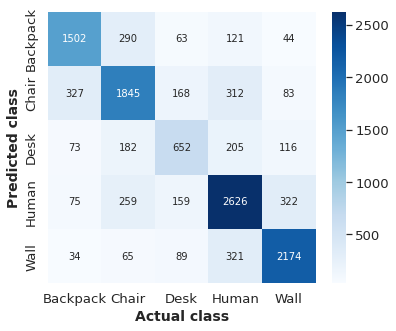

In [274]:
import seaborn as sn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 1000
%matplotlib inline
classe = ["Backpack", "Chair", "Desk", "Human", "Wall"]

mean_cf = np.mean([i for i in conf_mats],0)
mean_cf

df_cm = pd.DataFrame(mean_cf.astype(int), index = [i for i in classe],columns = [i for i in classe])
plt.figure(figsize = (6,5))


ax = sn.heatmap(df_cm, annot=True,fmt='g',cmap='Blues')

ax.set_xlabel(xlabel='Actual class', fontsize=14, fontdict=dict(weight='bold'))
ax.set_ylabel(ylabel='Predicted class', fontsize=14, fontdict=dict(weight='bold'))

plt.savefig('conf_mat_ppg_cross_attention.png', dpi=1000)